# Football Match Events Analysis
## Comprehensive Analysis Dashboard for Match Managers
### Data-Driven Insights for Better Decision Making

## Section 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
from scipy.spatial.distance import cdist
from datetime import datetime
import re

warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Section 2: Load and Explore the Dataset

In [2]:
# Load the dataset
with open(r'C:\Users\shrawan prasai\OneDrive\Desktop\bakchodi\16056.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Events: {len(df)}")
print(f"\nColumn Names and Data Types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW

Dataset Shape: (3388, 36)
Total Events: 3388

Column Names and Data Types:
id                  object
index                int64
period               int64
timestamp           object
minute               int64
second               int64
type                object
possession           int64
possession_team     object
play_pattern        object
team                object
duration           float64
tactics             object
related_events      object
player              object
position            object
location            object
pass                object
carry               object
under_pressure      object
duel                object
clearance           object
counterpress        object
shot                object
goalkeeper          object
interception        object
off_camera          object
ball_recovery       object
foul_won            object
ball_receipt        object
out                 object
foul_committed      object
dribble             object
substitution    

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,off_camera,ball_recovery,foul_won,ball_receipt,out,foul_committed,dribble,substitution,bad_behaviour,block
0,8553b2fc-af4b-46be-995f-5df83c3297db,1,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9a7f43a7-658b-4cce-81b2-b870e5fa4361,2,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5a639562-2ae8-45db-ae89-8b9bcc743c29,3,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dd140bc3-3537-4bd1-a15e-20e725fd11b5,4,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e586df2f-8a7e-4de8-bc99-5fbf5113c7f4,5,1,00:00:00.652,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 217, 'name': 'Barcelona'}","{'id': 9, 'name': 'From Kick Off'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Detailed dataset inspection
print("\n" + "=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

print("\n" + "=" * 80)
print("EVENT TYPES IN DATASET")
print("=" * 80)
event_types = df['type'].apply(lambda x: x.get('name') if isinstance(x, dict) else x).value_counts()
print(event_types)


MISSING VALUES ANALYSIS
                Missing_Count  Percentage
block                    3387   99.970484
bad_behaviour            3387   99.970484
tactics                  3383   99.852420
substitution             3382   99.822904
foul_won                 3380   99.763872
ball_recovery            3379   99.734357
foul_committed           3378   99.704841
interception             3362   99.232586
out                      3361   99.203070
dribble                  3360   99.173554
shot                     3353   98.966942
clearance                3352   98.937426
goalkeeper               3349   98.848878
off_camera               3336   98.465171
duel                     3324   98.110980
ball_receipt             3319   97.963400
counterpress             3300   97.402597
under_pressure           2841   83.854782
carry                    2638   77.863046
pass                     2403   70.926800
duration                  897   26.475797
related_events            155    4.574970
location 

## Section 3: Data Cleaning and Preprocessing

In [4]:
# Extract nested fields
df['event_type'] = df['type'].apply(lambda x: x.get('name') if isinstance(x, dict) else x)
df['team_name'] = df['team'].apply(lambda x: x.get('name') if isinstance(x, dict) else x)
df['possession_team_name'] = df['possession_team'].apply(lambda x: x.get('name') if isinstance(x, dict) else x)

# Extract player information
df['player_name'] = df['player'].apply(lambda x: x.get('name') if isinstance(x, dict) and x else 'N/A')
df['player_id'] = df['player'].apply(lambda x: x.get('id') if isinstance(x, dict) and x else None)

# Extract location data
df['location_x'] = df['location'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df['location_y'] = df['location'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)

# Extract end location for passes
df['end_location_x'] = df['pass'].apply(lambda x: x.get('end_location')[0] if isinstance(x, dict) and 'end_location' in x else None)
df['end_location_y'] = df['pass'].apply(lambda x: x.get('end_location')[1] if isinstance(x, dict) and 'end_location' in x else None)

# Extract pass completion
df['pass_successful'] = df['pass'].apply(lambda x: not x.get('incomplete', False) if isinstance(x, dict) else False)

# Extract shot data
df['shot_xg'] = df['shot'].apply(lambda x: x.get('expected_goals', None) if isinstance(x, dict) else None)
df['shot_result'] = df['shot'].apply(lambda x: x.get('result', {}).get('name') if isinstance(x, dict) else None)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f', errors='coerce')

# Combine minute and second for accurate timing
df['match_time_seconds'] = df['minute'] * 60 + df['second']

print("✓ Data cleaning and preprocessing completed")
print(f"\nExtracted columns: {df.columns.tolist()[-8:]}")

✓ Data cleaning and preprocessing completed

Extracted columns: ['location_x', 'location_y', 'end_location_x', 'end_location_y', 'pass_successful', 'shot_xg', 'shot_result', 'match_time_seconds']


## Section 4: Descriptive Statistics and Match Overview

In [5]:
# Get match information
teams = df['team_name'].unique()
match_duration = df['minute'].max()
total_events = len(df)

print("=" * 80)
print("MATCH OVERVIEW")
print("=" * 80)
print(f"Teams: {', '.join(teams)}")
print(f"Match Duration: {match_duration} minutes")
print(f"Total Events: {total_events}")

# Event statistics by type
print("\n" + "=" * 80)
print("EVENT STATISTICS BY TYPE")
print("=" * 80)
event_stats = df['event_type'].value_counts()
print(event_stats)

# Team statistics
print("\n" + "=" * 80)
print("EVENTS BY TEAM")
print("=" * 80)
team_events = df['team_name'].value_counts()
print(team_events)

# Key event counts
passes = len(df[df['event_type'] == 'Pass'])
shots = len(df[df['event_type'] == 'Shot'])
fouls = len(df[df['event_type'] == 'Foul Committed'])
dribbles = len(df[df['event_type'] == 'Dribble'])
interceptions = len(df[df['event_type'] == 'Interception'])

print("\n" + "=" * 80)
print("KEY EVENT COUNTS")
print("=" * 80)
print(f"Passes: {passes}")
print(f"Shots: {shots}")
print(f"Fouls Committed: {fouls}")
print(f"Dribbles: {dribbles}")
print(f"Interceptions: {interceptions}")

MATCH OVERVIEW
Teams: Barcelona, Real Betis
Match Duration: 94 minutes
Total Events: 3388

EVENT STATISTICS BY TYPE
event_type
Pass              985
Ball Receipt*     897
Carry             750
Pressure          268
Ball Recovery      85
Duel               64
Goal Keeper        39
Clearance          36
Block              35
Shot               35
Miscontrol         31
Dribble            28
Foul Committed     26
Interception       26
Foul Won           24
Dispossessed       23
Dribbled Past      14
Substitution        6
Half Start          4
Half End            4
Tactical Shift      3
Starting XI         2
Bad Behaviour       1
Error               1
Shield              1
Name: count, dtype: int64

EVENTS BY TEAM
team_name
Barcelona     1821
Real Betis    1567
Name: count, dtype: int64

KEY EVENT COUNTS
Passes: 985
Shots: 35
Fouls Committed: 26
Dribbles: 28
Interceptions: 26


In [6]:
# Visualize event distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Event Types Distribution", "Events by Team"),
    specs=[[{"type": "pie"}, {"type": "bar"}]]
)

# Top 10 event types
top_events = df['event_type'].value_counts().head(10)
fig.add_trace(
    go.Pie(labels=top_events.index, values=top_events.values, name="Events"),
    row=1, col=1
)

# Events by team
team_event_counts = df[df['event_type'].isin(['Pass', 'Shot', 'Dribble', 'Tackle'])].groupby('team_name')['event_type'].count()
fig.add_trace(
    go.Bar(x=team_event_counts.index, y=team_event_counts.values, name="Key Events", showlegend=False),
    row=1, col=2
)

fig.update_layout(height=500, title_text="Match Event Overview", showlegend=True)
fig.show()

print("✓ Event distribution visualization completed")

✓ Event distribution visualization completed


## Section 5: Player Performance Analysis

In [7]:
# Player Statistics
player_stats = []

for player in df[df['player_name'] != 'N/A']['player_name'].unique():
    player_data = df[df['player_name'] == player]
    team = player_data['team_name'].iloc[0] if len(player_data) > 0 else 'Unknown'
    
    passes = len(player_data[player_data['event_type'] == 'Pass'])
    passes_completed = len(player_data[player_data['event_type'] == 'Pass'][player_data['pass_successful'] == True])
    pass_accuracy = (passes_completed / passes * 100) if passes > 0 else 0
    
    shots = len(player_data[player_data['event_type'] == 'Shot'])
    dribbles = len(player_data[player_data['event_type'] == 'Dribble'])
    tackles = len(player_data[player_data['event_type'] == 'Tackle'])
    interceptions = len(player_data[player_data['event_type'] == 'Interception'])
    fouls = len(player_data[player_data['event_type'] == 'Foul Committed'])
    
    total_events = len(player_data)
    
    player_stats.append({
        'Player': player,
        'Team': team,
        'Total Events': total_events,
        'Passes': passes,
        'Pass Accuracy (%)': round(pass_accuracy, 2),
        'Shots': shots,
        'Dribbles': dribbles,
        'Tackles': tackles,
        'Interceptions': interceptions,
        'Fouls': fouls
    })

player_stats_df = pd.DataFrame(player_stats).sort_values('Total Events', ascending=False)

print("=" * 80)
print("TOP 15 PLAYERS BY ACTIVITY")
print("=" * 80)
print(player_stats_df.head(15))

# Top passers
print("\n" + "=" * 80)
print("TOP 10 PASSERS")
print("=" * 80)
top_passers = player_stats_df.nlargest(10, 'Passes')[['Player', 'Team', 'Passes', 'Pass Accuracy (%)']]
print(top_passers)

TOP 15 PLAYERS BY ACTIVITY
                               Player        Team  Total Events  Passes  \
13    Lionel AndrÃ©s Messi Cuccittini   Barcelona           228      55   
12                   Jordi Alba Ramos   Barcelona           203      67   
2                       Ivan RakitiÄ‡   Barcelona           198      63   
7                        AÃ¯ssa Mandi  Real Betis           168      54   
17                   Giovani Lo Celso  Real Betis           166      42   
3              Sergi Roberto Carnicer   Barcelona           165      56   
15          William Silva de Carvalho  Real Betis           157      51   
4             Gerard PiquÃ© BernabÃ©u   Barcelona           156      56   
14  JosÃ© AndrÃ©s Guardado HernÃ¡ndez  Real Betis           153      48   
0          Luis Alberto SuÃ¡rez DÃ­az   Barcelona           143      35   
11             Cristian Tello Herrera  Real Betis           142      40   
5                    ClÃ©ment Lenglet   Barcelona           138      42  

In [8]:
# Player Performance Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Top 10 Passers", "Top 10 Shooters", "Top 10 Defenders (Tackles)", "Top 10 Ball Winners (Interceptions)"),
    specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "bar"}, {"type": "bar"}]]
)

# Top passers
top_10_passers = player_stats_df.nlargest(10, 'Passes')
fig.add_trace(go.Bar(x=top_10_passers['Player'], y=top_10_passers['Passes'], name='Passes'), row=1, col=1)

# Top shooters
top_10_shooters = player_stats_df.nlargest(10, 'Shots')
fig.add_trace(go.Bar(x=top_10_shooters['Player'], y=top_10_shooters['Shots'], name='Shots', marker_color='orange'), row=1, col=2)

# Top defenders
top_10_tacklers = player_stats_df.nlargest(10, 'Tackles')
fig.add_trace(go.Bar(x=top_10_tacklers['Player'], y=top_10_tacklers['Tackles'], name='Tackles', marker_color='red'), row=2, col=1)

# Top interceptions
top_10_intercept = player_stats_df.nlargest(10, 'Interceptions')
fig.add_trace(go.Bar(x=top_10_intercept['Player'], y=top_10_intercept['Interceptions'], name='Interceptions', marker_color='green'), row=2, col=2)

fig.update_xaxes(tickangle=-45)
fig.update_layout(height=800, title_text="Player Performance Metrics", showlegend=False)
fig.show()

print("✓ Player performance visualization completed")

✓ Player performance visualization completed


## Section 6: Pass Completion and Accuracy Heatmaps

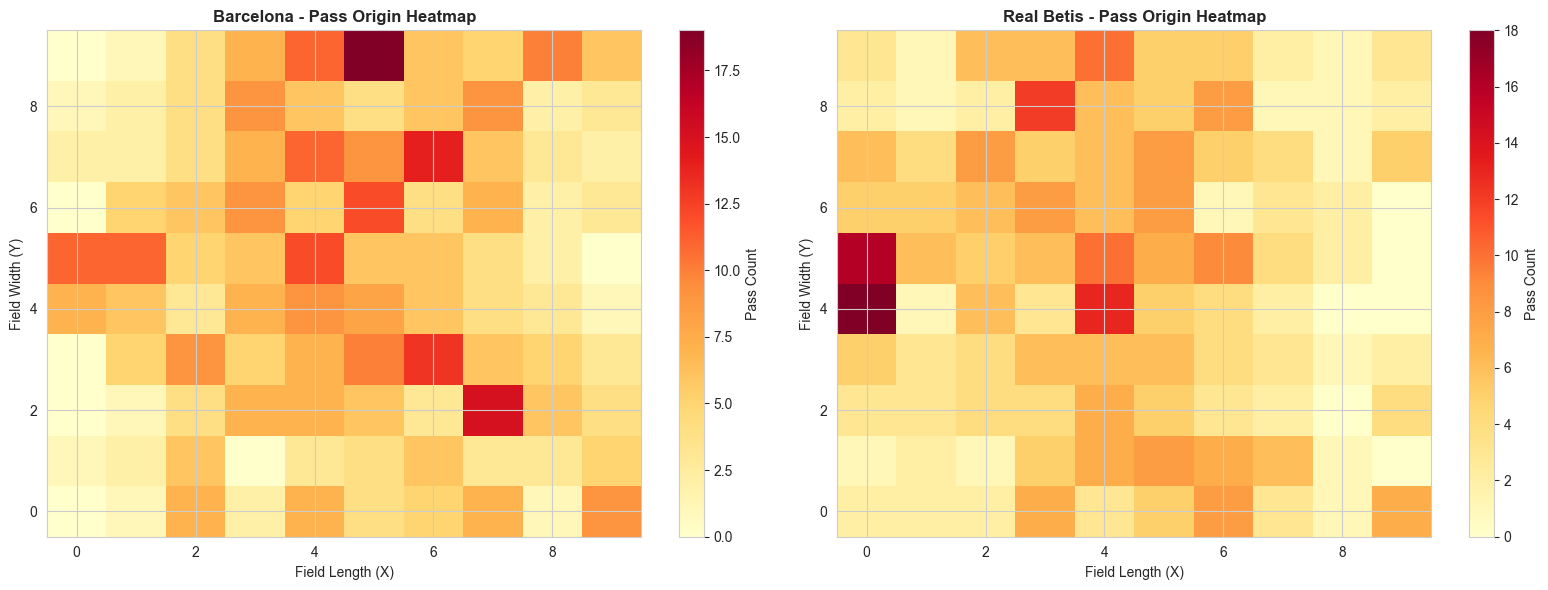

✓ Pass origin heatmaps created


In [9]:
# Create pitch zones for heatmap analysis
def create_pitch_zones(x, y, num_zones=5):
    """Divide pitch into zones for heatmap analysis"""
    if pd.isna(x) or pd.isna(y):
        return None
    zone_x = int(x // (120 / num_zones))  # Pitch is 120 yards long
    zone_y = int(y // (80 / num_zones))   # Pitch is 80 yards wide
    return (min(zone_x, num_zones-1), min(zone_y, num_zones-1))

# Get pass events with location data
passes_df = df[df['event_type'] == 'Pass'].dropna(subset=['location_x', 'location_y'])

# Create zone heatmap for both teams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, team in enumerate(teams):
    team_passes = passes_df[passes_df['team_name'] == team]
    
    # Create 2D histogram for pass origin locations
    heatmap_data, xedges, yedges = np.histogram2d(
        team_passes['location_x'], 
        team_passes['location_y'],
        bins=10
    )
    
    im = axes[idx].imshow(heatmap_data.T, origin='lower', cmap='YlOrRd', aspect='auto')
    axes[idx].set_title(f'{team} - Pass Origin Heatmap', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Field Length (X)')
    axes[idx].set_ylabel('Field Width (Y)')
    plt.colorbar(im, ax=axes[idx], label='Pass Count')

plt.tight_layout()
plt.show()

print("✓ Pass origin heatmaps created")

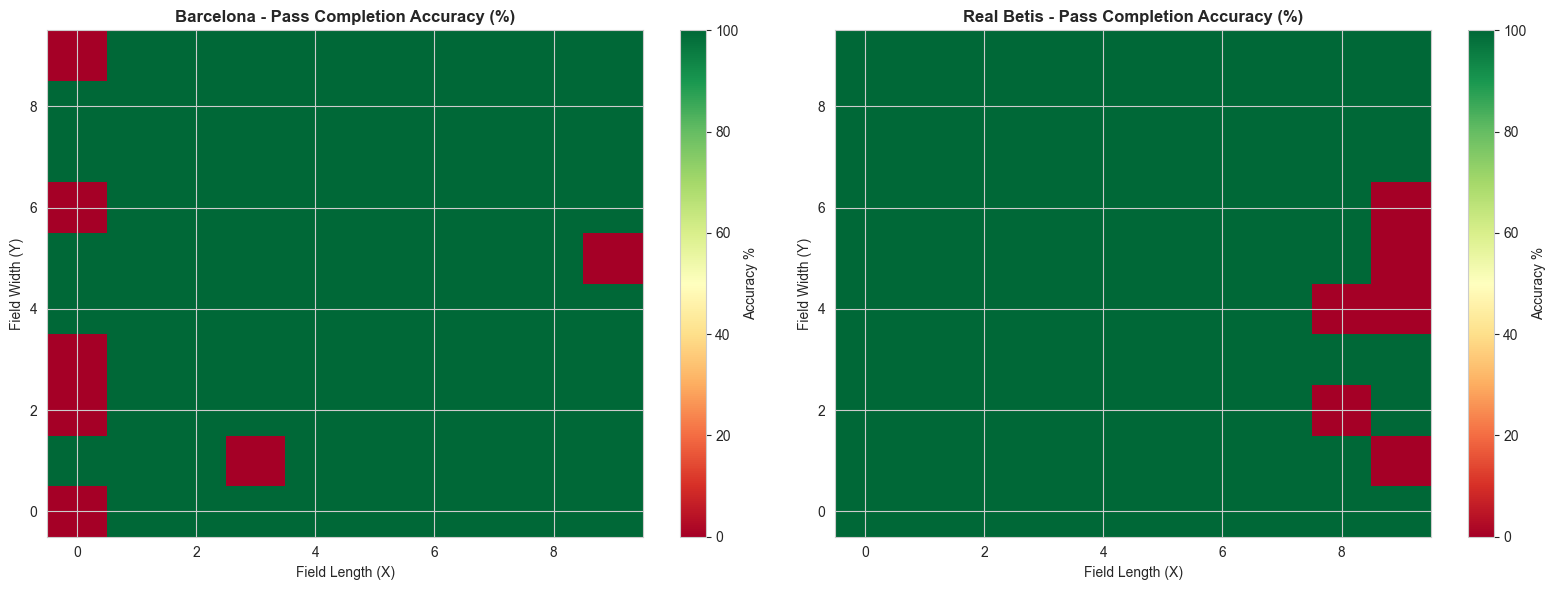

✓ Pass completion accuracy heatmaps created


In [10]:
# Pass Completion Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, team in enumerate(teams):
    team_passes = passes_df[passes_df['team_name'] == team].copy()
    team_passes = team_passes.dropna(subset=['location_x', 'location_y'])
    
    # Create completion accuracy heatmap
    successful_passes = team_passes[team_passes['pass_successful'] == True]
    
    # Bin the data
    h, xedges, yedges = np.histogram2d(
        team_passes['location_x'],
        team_passes['location_y'],
        bins=10
    )
    
    h_success, _, _ = np.histogram2d(
        successful_passes['location_x'],
        successful_passes['location_y'],
        bins=[xedges, yedges]
    )
    
    # Calculate pass accuracy
    with np.errstate(divide='ignore', invalid='ignore'):
        accuracy = np.where(h > 0, (h_success / h) * 100, 0)
    
    im = axes[idx].imshow(accuracy.T, origin='lower', cmap='RdYlGn', vmin=0, vmax=100, aspect='auto')
    axes[idx].set_title(f'{team} - Pass Completion Accuracy (%)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Field Length (X)')
    axes[idx].set_ylabel('Field Width (Y)')
    cbar = plt.colorbar(im, ax=axes[idx], label='Accuracy %')

plt.tight_layout()
plt.show()

print("✓ Pass completion accuracy heatmaps created")

## Section 7: Shot Analysis and Goal Probability

SHOT ANALYSIS
Total Shots: 35

Shots by Team:
team_name
Barcelona     20
Real Betis    15
Name: count, dtype: int64

Shot Results Distribution:
Series([], Name: count, dtype: int64)

Total Expected Goals (xG): 0.00
xG by Team:
team_name
Barcelona     0.0
Real Betis    0.0
Name: shot_xg, dtype: float64


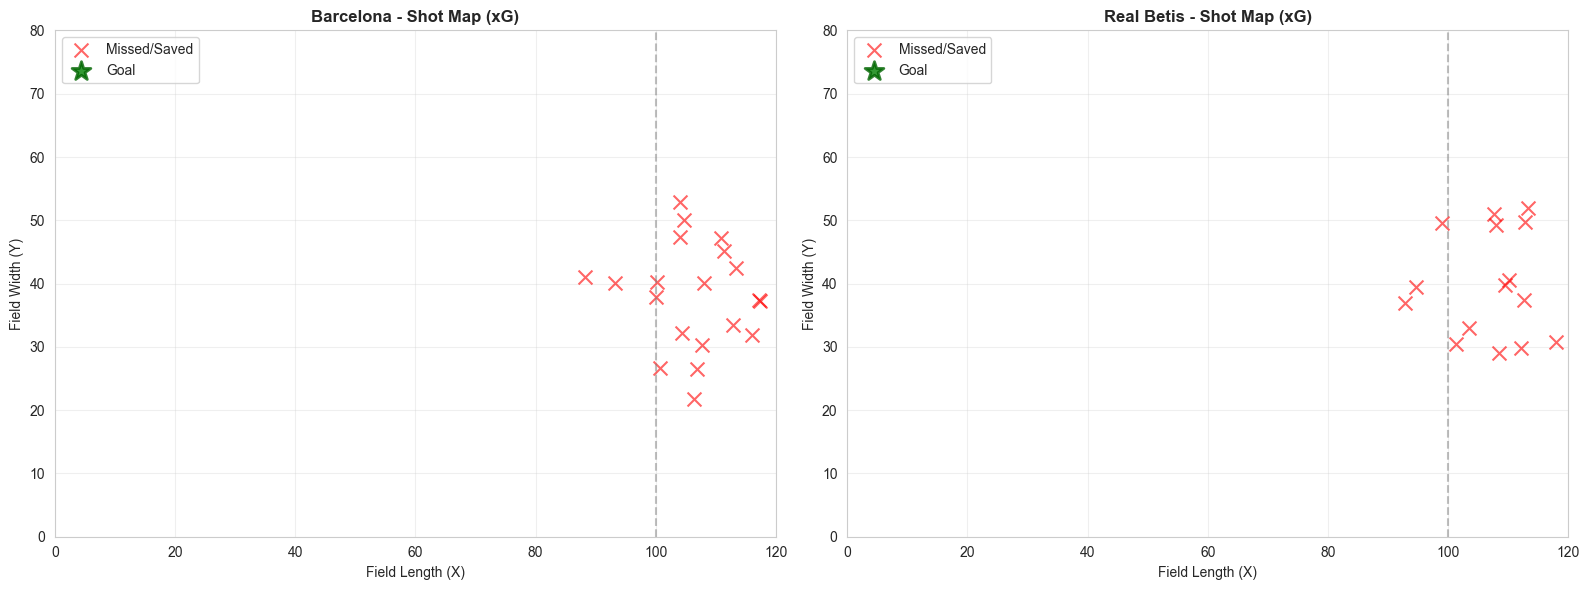


✓ Shot analysis and visualization completed


In [11]:
# Shot Analysis
shots_df = df[df['event_type'] == 'Shot'].dropna(subset=['location_x', 'location_y']).copy()

print("=" * 80)
print("SHOT ANALYSIS")
print("=" * 80)
print(f"Total Shots: {len(shots_df)}")
print(f"\nShots by Team:")
print(shots_df['team_name'].value_counts())

print(f"\nShot Results Distribution:")
print(shots_df['shot_result'].value_counts())

# Calculate xG
shots_df['shot_xg'] = pd.to_numeric(shots_df['shot_xg'], errors='coerce')
total_xg = shots_df['shot_xg'].sum()
print(f"\nTotal Expected Goals (xG): {total_xg:.2f}")

# xG by team
xg_by_team = shots_df.groupby('team_name')['shot_xg'].sum()
print(f"xG by Team:")
print(xg_by_team)

# Visualize shots on pitch
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, team in enumerate(teams):
    team_shots = shots_df[shots_df['team_name'] == team]
    successful = team_shots[team_shots['shot_result'] == 'Goal']
    unsuccessful = team_shots[team_shots['shot_result'] != 'Goal']
    
    axes[idx].scatter(unsuccessful['location_x'], unsuccessful['location_y'], 
                     s=100, alpha=0.6, c='red', label='Missed/Saved', marker='x')
    axes[idx].scatter(successful['location_x'], successful['location_y'], 
                     s=200, alpha=0.8, c='green', label='Goal', marker='*', edgecolors='darkgreen', linewidth=2)
    
    axes[idx].set_xlim(0, 120)
    axes[idx].set_ylim(0, 80)
    axes[idx].set_title(f'{team} - Shot Map (xG)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Field Length (X)')
    axes[idx].set_ylabel('Field Width (Y)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    
    # Add pitch markings
    axes[idx].axvline(x=100, color='gray', linestyle='--', alpha=0.5)  # Penalty area

plt.tight_layout()
plt.show()

print("\n✓ Shot analysis and visualization completed")

## Section 8: Possession and Territory Heatmaps

POSSESSION STATISTICS
Barcelona: 1810 events (53.7% possession)
Real Betis: 1558 events (46.3% possession)


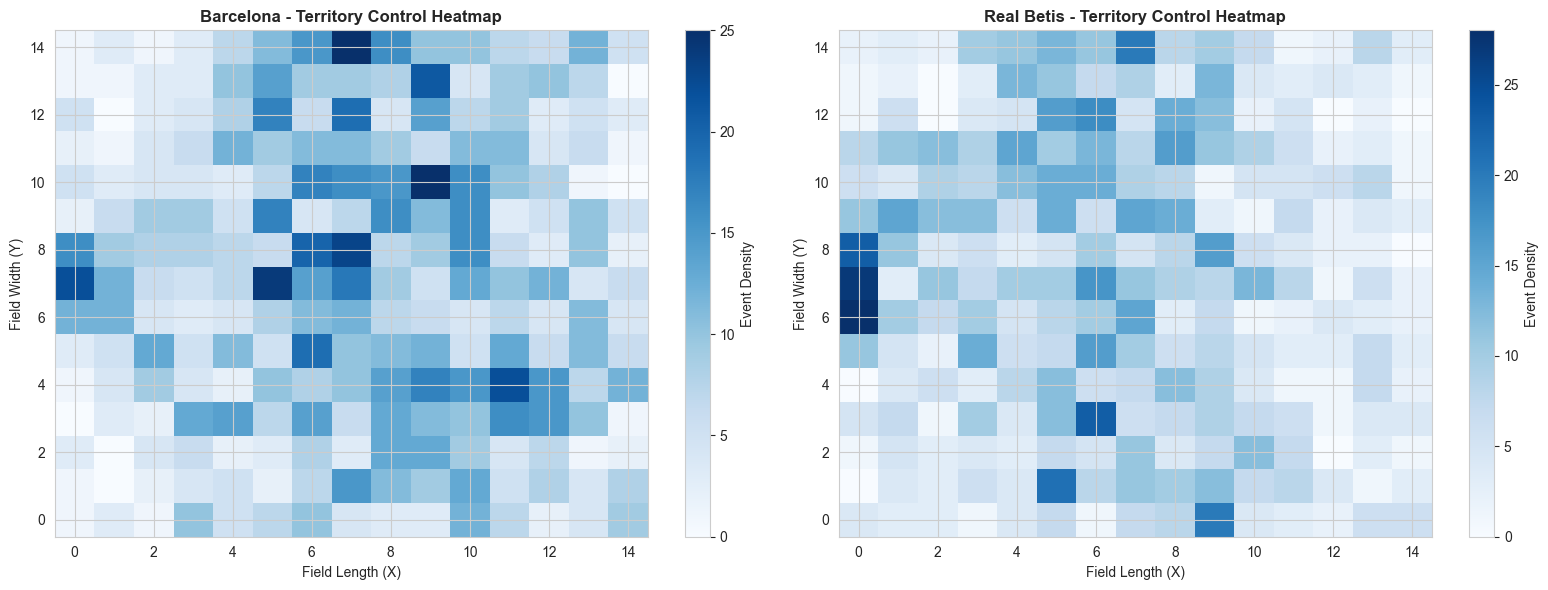


✓ Possession and territory heatmaps created


In [12]:
# Possession and Territory Analysis
events_with_loc = df.dropna(subset=['location_x', 'location_y'])

print("=" * 80)
print("POSSESSION STATISTICS")
print("=" * 80)

# Possession count
for team in teams:
    team_events = events_with_loc[events_with_loc['team_name'] == team]
    total_team_events = len(team_events)
    possession_pct = (total_team_events / len(events_with_loc)) * 100
    print(f"{team}: {total_team_events} events ({possession_pct:.1f}% possession)")

# Territory Heatmap - where teams spend the ball
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, team in enumerate(teams):
    team_events = events_with_loc[events_with_loc['team_name'] == team]
    
    # Create 2D density map
    h, xedges, yedges = np.histogram2d(
        team_events['location_x'],
        team_events['location_y'],
        bins=15
    )
    
    im = axes[idx].imshow(h.T, origin='lower', cmap='Blues', aspect='auto')
    axes[idx].set_title(f'{team} - Territory Control Heatmap', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Field Length (X)')
    axes[idx].set_ylabel('Field Width (Y)')
    cbar = plt.colorbar(im, ax=axes[idx], label='Event Density')

plt.tight_layout()
plt.show()

print("\n✓ Possession and territory heatmaps created")

## Section 9: Pressing and Defensive Actions

DEFENSIVE ACTIONS ANALYSIS

Barcelona:
  Total Defensive Actions: 86
  Tackles: 0
  Interceptions: 12
  Fouls Committed: 14

Real Betis:
  Total Defensive Actions: 101
  Tackles: 0
  Interceptions: 14
  Fouls Committed: 12


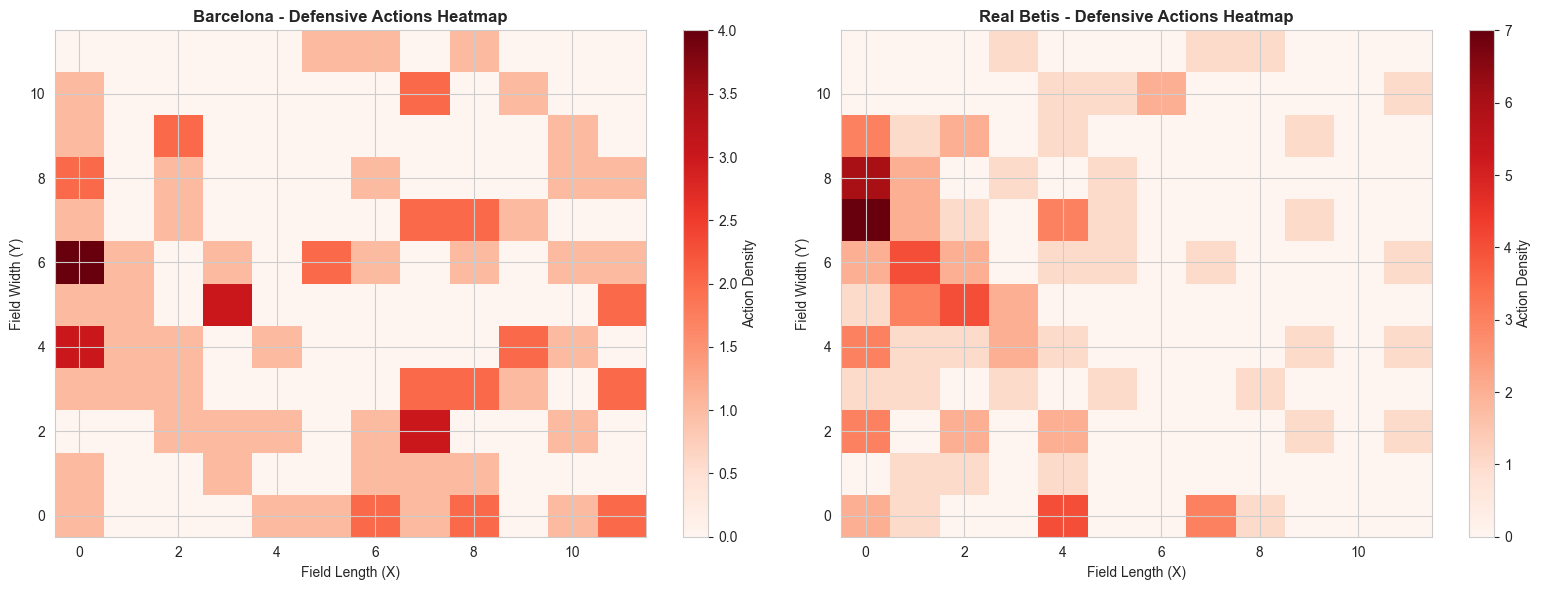


✓ Defensive actions analysis completed


In [13]:
# Defensive Actions Analysis
print("=" * 80)
print("DEFENSIVE ACTIONS ANALYSIS")
print("=" * 80)

defensive_events = ['Tackle', 'Interception', 'Clearance', 'Foul Committed', 'Duel', 'Block']
df['is_defensive'] = df['event_type'].isin(defensive_events)

# Defensive stats by team
for team in teams:
    team_data = df[df['team_name'] == team]
    defensive_count = team_data['is_defensive'].sum()
    tackles = len(team_data[team_data['event_type'] == 'Tackle'])
    interceptions = len(team_data[team_data['event_type'] == 'Interception'])
    fouls = len(team_data[team_data['event_type'] == 'Foul Committed'])
    
    print(f"\n{team}:")
    print(f"  Total Defensive Actions: {defensive_count}")
    print(f"  Tackles: {tackles}")
    print(f"  Interceptions: {interceptions}")
    print(f"  Fouls Committed: {fouls}")

# Defensive Action Heatmaps
defensive_df = df[df['is_defensive']].dropna(subset=['location_x', 'location_y'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, team in enumerate(teams):
    team_defensive = defensive_df[defensive_df['team_name'] == team]
    
    h, xedges, yedges = np.histogram2d(
        team_defensive['location_x'],
        team_defensive['location_y'],
        bins=12
    )
    
    im = axes[idx].imshow(h.T, origin='lower', cmap='Reds', aspect='auto')
    axes[idx].set_title(f'{team} - Defensive Actions Heatmap', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Field Length (X)')
    axes[idx].set_ylabel('Field Width (Y)')
    cbar = plt.colorbar(im, ax=axes[idx], label='Action Density')

plt.tight_layout()
plt.show()

print("\n✓ Defensive actions analysis completed")

## Section 10: Player Clustering and Similarity Analysis

PLAYER CLUSTERING ANALYSIS (K-MEANS, K=4)

Player Profiles by Cluster:

Cluster 0 - Defensive Players (10 players)
                                Player       Team  Passes  Shots  Tackles  Pass Accuracy (%)
            Luis Alberto SuÃ¡rez DÃ­az  Barcelona      35      3        0              100.0
Arthur Henrique Ramos de Oliveira Melo  Barcelona      34      0        0              100.0
          JoaquÃ­n SÃ¡nchez RodrÃ­guez Real Betis      26      2        0              100.0
             Arturo Erasmo Vidal Pardo  Barcelona      17      2        0              100.0
                Marc-AndrÃ© ter Stegen  Barcelona      31      0        0              100.0
       Malcom Filipe Silva de Oliveira  Barcelona      16      1        0              100.0
                Sergio Canales Madrazo Real Betis      18      2        0              100.0
                Carles AleÃ±a Castillo  Barcelona      16      1        0              100.0
              Munir El Haddadi Mohamed  Barcelon

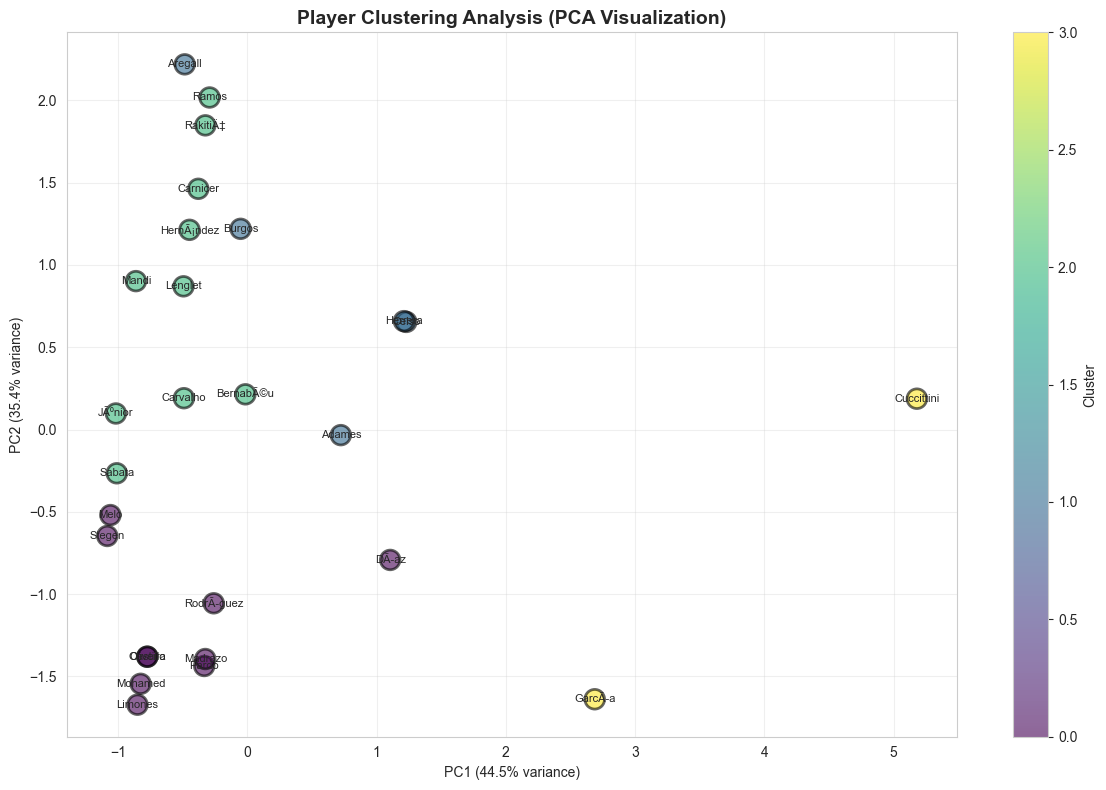


✓ Player clustering analysis completed


In [14]:
# K-Means Clustering of Players
# Prepare data for clustering - use top players with enough activity
top_players = player_stats_df[player_stats_df['Total Events'] >= 20].copy()

# Normalize features for clustering
scaler = StandardScaler()
features = ['Passes', 'Shots', 'Tackles', 'Interceptions', 'Dribbles', 'Pass Accuracy (%)']
X = top_players[features].fillna(0)
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
top_players['Cluster'] = kmeans.fit_predict(X_scaled)

print("=" * 80)
print("PLAYER CLUSTERING ANALYSIS (K-MEANS, K=4)")
print("=" * 80)
print(f"\nPlayer Profiles by Cluster:")

cluster_labels = {
    0: 'Defensive Players',
    1: 'Attacking Players', 
    2: 'Midfield Creators',
    3: 'All-Rounders'
}

for cluster in range(4):
    cluster_players = top_players[top_players['Cluster'] == cluster]
    print(f"\nCluster {cluster} - {cluster_labels.get(cluster, 'Cluster ' + str(cluster))} ({len(cluster_players)} players)")
    print(cluster_players[['Player', 'Team', 'Passes', 'Shots', 'Tackles', 'Pass Accuracy (%)']].to_string(index=False))

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=top_players['Cluster'], 
                     cmap='viridis', s=200, alpha=0.6, edgecolors='black', linewidth=2)

# Annotate points with player names
for i, player in enumerate(top_players['Player'].values):
    ax.annotate(player.split()[-1], (X_pca[i, 0], X_pca[i, 1]), 
               fontsize=8, ha='center', va='center')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('Player Clustering Analysis (PCA Visualization)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

print("\n✓ Player clustering analysis completed")

## Section 11: Match Momentum and Time-Series Analysis

MATCH MOMENTUM ANALYSIS


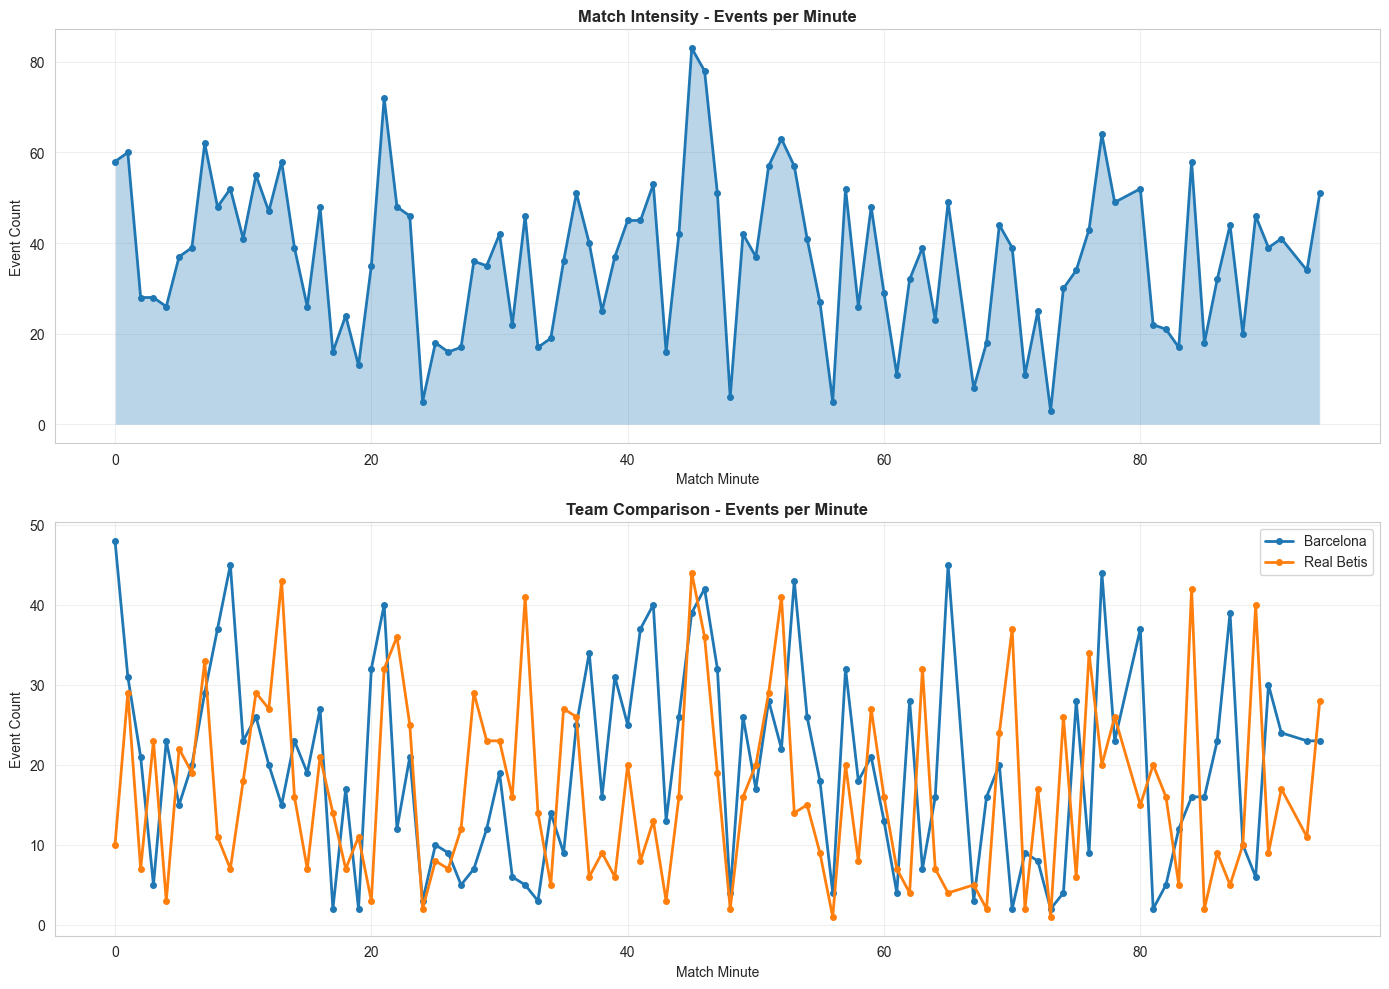


Momentum by 15-minute intervals:
Barcelona (0-15 min): 381 events
Barcelona (15-30 min): 218 events
Barcelona (30-45 min): 303 events
Barcelona (45-60 min): 372 events
Barcelona (60-75 min): 177 events
Barcelona (75-90 min): 270 events
Barcelona (90-105 min): 100 events

Real Betis (0-15 min): 297 events
Real Betis (15-30 min): 237 events
Real Betis (30-45 min): 233 events
Real Betis (45-60 min): 301 events
Real Betis (60-75 min): 184 events
Real Betis (75-90 min): 250 events
Real Betis (90-105 min): 65 events

✓ Match momentum analysis completed


In [15]:
# Time-Series Analysis - Match Momentum
print("=" * 80)
print("MATCH MOMENTUM ANALYSIS")
print("=" * 80)

# Events over time
time_bins = range(0, int(df['minute'].max()) + 5, 5)  # 5-minute intervals
df['time_bin'] = pd.cut(df['minute'], bins=time_bins)

# Count events by team and time bin
momentum_data = []
for team in teams:
    team_df = df[df['team_name'] == team]
    events_by_time = team_df.groupby('time_bin').size()
    for time_bin, count in events_by_time.items():
        momentum_data.append({
            'Team': team,
            'Time_Bin': str(time_bin),
            'Events': count
        })

momentum_df = pd.DataFrame(momentum_data)

# Visualize momentum
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Overall event frequency over time
events_per_minute = df.groupby('minute')['event_type'].count()
axes[0].plot(events_per_minute.index, events_per_minute.values, marker='o', linewidth=2, markersize=4)
axes[0].fill_between(events_per_minute.index, events_per_minute.values, alpha=0.3)
axes[0].set_title('Match Intensity - Events per Minute', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Match Minute')
axes[0].set_ylabel('Event Count')
axes[0].grid(True, alpha=0.3)

# Team comparison over time
for team in teams:
    team_df = df[df['team_name'] == team]
    team_events_per_minute = team_df.groupby('minute')['event_type'].count()
    axes[1].plot(team_events_per_minute.index, team_events_per_minute.values, 
                label=team, marker='o', linewidth=2, markersize=4)

axes[1].set_title('Team Comparison - Events per Minute', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Match Minute')
axes[1].set_ylabel('Event Count')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate momentum shifts
print("\nMomentum by 15-minute intervals:")
for team in teams:
    team_df = df[df['team_name'] == team]
    for period in range(0, int(df['minute'].max()), 15):
        period_events = len(team_df[(team_df['minute'] >= period) & (team_df['minute'] < period + 15)])
        print(f"{team} ({period}-{period+15} min): {period_events} events")
    print()

print("✓ Match momentum analysis completed")

## Section 12: Predictive Modeling for Match Outcomes

In [16]:
# Prepare features for predictive modeling by team
print("=" * 80)
print("PREDICTIVE MODELING - MATCH PERFORMANCE FEATURES")
print("=" * 80)

team_features = []

for team in teams:
    team_df = df[df['team_name'] == team]
    team_passes = team_df[team_df['event_type'] == 'Pass']
    team_shots = team_df[team_df['event_type'] == 'Shot']
    team_defensive = team_df[team_df['is_defensive']]
    
    total_passes = len(team_passes)
    completed_passes = len(team_passes[team_passes['pass_successful'] == True])
    pass_accuracy = (completed_passes / total_passes * 100) if total_passes > 0 else 0
    
    total_shots = len(team_shots)
    goals = len(team_shots[team_shots['shot_result'] == 'Goal'])
    xg_total = team_shots['shot_xg'].sum()
    
    tackles = len(team_df[team_df['event_type'] == 'Tackle'])
    interceptions = len(team_df[team_df['event_type'] == 'Interception'])
    fouls = len(team_df[team_df['event_type'] == 'Foul Committed'])
    
    dribbles = len(team_df[team_df['event_type'] == 'Dribble'])
    
    # Calculate possession percentage
    possession_pct = (len(team_df) / len(df)) * 100
    
    team_features.append({
        'Team': team,
        'Total_Events': len(team_df),
        'Possession_%': round(possession_pct, 2),
        'Passes': total_passes,
        'Pass_Accuracy_%': round(pass_accuracy, 2),
        'Shots': total_shots,
        'Goals': goals,
        'xG': round(xg_total, 2),
        'Tackles': tackles,
        'Interceptions': interceptions,
        'Fouls': fouls,
        'Dribbles': dribbles,
        'Defensive_Actions': len(team_defensive)
    })

team_stats = pd.DataFrame(team_features)
print(team_stats.to_string(index=False))

# Create performance score
print("\n" + "=" * 80)
print("TEAM PERFORMANCE METRICS")
print("=" * 80)

for idx, row in team_stats.iterrows():
    # Weighted scoring system
    pass_score = row['Pass_Accuracy_%'] / 100
    shot_score = row['Goals'] + (row['xG'] * 0.5)
    defense_score = (row['Tackles'] + row['Interceptions']) / (row['Fouls'] + 1)
    
    overall_score = (pass_score * 0.3 + shot_score * 0.4 + defense_score * 0.3)
    
    print(f"\n{row['Team']}:")
    print(f"  Possession: {row['Possession_%']:.1f}%")
    print(f"  Passing Accuracy: {row['Pass_Accuracy_%']:.1f}%")
    print(f"  Attacking Threat (Goals + xG): {row['Goals'] + row['xG']:.2f}")
    print(f"  Defensive Strength: {defense_score:.2f}")
    print(f"  Overall Performance Score: {overall_score:.2f}/10")

PREDICTIVE MODELING - MATCH PERFORMANCE FEATURES
      Team  Total_Events  Possession_%  Passes  Pass_Accuracy_%  Shots  Goals  xG  Tackles  Interceptions  Fouls  Dribbles  Defensive_Actions
 Barcelona          1821         53.75     537            100.0     20      0   0        0             12     14        12                 86
Real Betis          1567         46.25     448            100.0     15      0   0        0             14     12        16                101

TEAM PERFORMANCE METRICS

Barcelona:
  Possession: 53.8%
  Passing Accuracy: 100.0%
  Attacking Threat (Goals + xG): 0.00
  Defensive Strength: 0.80
  Overall Performance Score: 0.54/10

Real Betis:
  Possession: 46.2%
  Passing Accuracy: 100.0%
  Attacking Threat (Goals + xG): 0.00
  Defensive Strength: 1.08
  Overall Performance Score: 0.62/10


In [17]:
# Visualize Team Performance Comparison
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Possession %", "Pass Accuracy %", "Goals + xG", "Defensive Actions"),
    specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "bar"}, {"type": "bar"}]]
)

fig.add_trace(
    go.Bar(x=team_stats['Team'], y=team_stats['Possession_%'], name='Possession', marker_color='lightblue'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=team_stats['Team'], y=team_stats['Pass_Accuracy_%'], name='Pass Accuracy', marker_color='lightgreen'),
    row=1, col=2
)

team_stats['Goals_xG'] = team_stats['Goals'] + team_stats['xG']
fig.add_trace(
    go.Bar(x=team_stats['Team'], y=team_stats['Goals_xG'], name='Goals + xG', marker_color='lightcoral'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=team_stats['Team'], y=team_stats['Defensive_Actions'], name='Defensive Actions', marker_color='lightyellow'),
    row=2, col=2
)

fig.update_layout(height=700, title_text="Team Performance Comparison Dashboard", showlegend=False)
fig.show()

print("✓ Team performance comparison completed")

✓ Team performance comparison completed


## Section 13: Interactive Dashboard Summary and Manager Insights

In [18]:
print("=" * 100)
print("COMPREHENSIVE MANAGER INSIGHTS - EXECUTIVE SUMMARY")
print("=" * 100)

# Get primary team (usually Barcelona based on data)
primary_team = teams[0]
opponent_team = teams[1]

primary_team_stats = team_stats[team_stats['Team'] == primary_team].iloc[0]
opponent_stats = team_stats[team_stats['Team'] == opponent_team].iloc[0]

print(f"\n{'MATCH OVERVIEW':^100}")
print("-" * 100)
print(f"Match Duration: {int(df['minute'].max())} minutes")
print(f"Total Events Analyzed: {len(df)}")
print(f"Teams: {primary_team} vs {opponent_team}")

print(f"\n{'POSSESSION & TERRITORY CONTROL':^100}")
print("-" * 100)
print(f"{primary_team} Possession: {primary_team_stats['Possession_%']:.1f}%")
print(f"{opponent_team} Possession: {opponent_stats['Possession_%']:.1f}%")

if primary_team_stats['Possession_%'] > opponent_stats['Possession_%']:
    advantage = primary_team_stats['Possession_%'] - opponent_stats['Possession_%']
    print(f"✓ {primary_team} dominated possession by {advantage:.1f} percentage points")
else:
    advantage = opponent_stats['Possession_%'] - primary_team_stats['Possession_%']
    print(f"! {opponent_team} dominated possession by {advantage:.1f} percentage points")

print(f"\n{'ATTACKING PERFORMANCE':^100}")
print("-" * 100)
print(f"{primary_team}:")
print(f"  - Shots: {int(primary_team_stats['Shots'])}")
print(f"  - Goals: {int(primary_team_stats['Goals'])}")
print(f"  - Expected Goals (xG): {primary_team_stats['xG']:.2f}")
print(f"  - Shooting Accuracy: {(primary_team_stats['Goals'] / max(1, primary_team_stats['Shots']) * 100):.1f}%")

print(f"\n{opponent_team}:")
print(f"  - Shots: {int(opponent_stats['Shots'])}")
print(f"  - Goals: {int(opponent_stats['Goals'])}")
print(f"  - Expected Goals (xG): {opponent_stats['xG']:.2f}")
print(f"  - Shooting Accuracy: {(opponent_stats['Goals'] / max(1, opponent_stats['Shots']) * 100):.1f}%")

# Determine attacking advantage
primary_threat = primary_team_stats['Goals'] + primary_team_stats['xG']
opponent_threat = opponent_stats['Goals'] + opponent_stats['xG']

if primary_threat > opponent_threat:
    print(f"✓ {primary_team} created more scoring opportunities (Threat Index: {primary_threat:.2f} vs {opponent_threat:.2f})")
else:
    print(f"! {opponent_team} created more scoring opportunities (Threat Index: {opponent_threat:.2f} vs {primary_threat:.2f})")

print(f"\n{'PASSING & PLAY BUILDUP':^100}")
print("-" * 100)
print(f"{primary_team} Pass Statistics:")
print(f"  - Total Passes: {int(primary_team_stats['Passes'])}")
print(f"  - Pass Accuracy: {primary_team_stats['Pass_Accuracy_%']:.1f}%")

print(f"\n{opponent_team} Pass Statistics:")
print(f"  - Total Passes: {int(opponent_stats['Passes'])}")
print(f"  - Pass Accuracy: {opponent_stats['Pass_Accuracy_%']:.1f}%")

if primary_team_stats['Pass_Accuracy_%'] > opponent_stats['Pass_Accuracy_%']:
    print(f"✓ {primary_team} showed better control with {primary_team_stats['Pass_Accuracy_%']:.1f}% accuracy")
else:
    print(f"! {opponent_team} showed better control with {opponent_stats['Pass_Accuracy_%']:.1f}% accuracy")

print(f"\n{'DEFENSIVE PERFORMANCE':^100}")
print("-" * 100)
print(f"{primary_team} Defensive Stats:")
print(f"  - Tackles Won: {int(primary_team_stats['Tackles'])}")
print(f"  - Interceptions: {int(primary_team_stats['Interceptions'])}")
print(f"  - Fouls Committed: {int(primary_team_stats['Fouls'])}")
print(f"  - Defensive Efficiency: {(primary_team_stats['Tackles'] + primary_team_stats['Interceptions']) / max(1, primary_team_stats['Fouls'] + 1):.2f}")

print(f"\n{opponent_team} Defensive Stats:")
print(f"  - Tackles Won: {int(opponent_stats['Tackles'])}")
print(f"  - Interceptions: {int(opponent_stats['Interceptions'])}")
print(f"  - Fouls Committed: {int(opponent_stats['Fouls'])}")
print(f"  - Defensive Efficiency: {(opponent_stats['Tackles'] + opponent_stats['Interceptions']) / max(1, opponent_stats['Fouls'] + 1):.2f}")

print(f"\n{'TOP 5 MATCH INFLUENCERS':^100}")
print("-" * 100)
top_5_players = player_stats_df.head(5)[['Player', 'Team', 'Total Events', 'Passes', 'Pass Accuracy (%)', 'Tackles', 'Interceptions']]
print(top_5_players.to_string(index=False))

print(f"\n{'KEY RECOMMENDATIONS FOR {}'.format(primary_team):^100}")
print("-" * 100)

recommendations = []

# Possession-based recommendation
if primary_team_stats['Possession_%'] < 45:
    recommendations.append(f"• Increase possession control - Currently {primary_team_stats['Possession_%']:.1f}%, need to dominate midfield")
elif primary_team_stats['Possession_%'] > 60:
    recommendations.append(f"• Maintain possession control - Successfully dominating with {primary_team_stats['Possession_%']:.1f}% possession")

# Passing recommendation
if primary_team_stats['Pass_Accuracy_%'] < 75:
    recommendations.append("• Improve pass accuracy - Focus on shorter, safer passes to build play from defense")
else:
    recommendations.append(f"• Maintain high passing accuracy at {primary_team_stats['Pass_Accuracy_%']:.1f}%")

# Attacking recommendation
if primary_team_stats['xG'] < 1.5:
    recommendations.append("• Increase shot volume - Work on creating more clear-cut chances in the final third")
else:
    recommendations.append(f"• Continue clinical finishing - Creating good opportunities with {primary_team_stats['xG']:.2f} xG")

# Defensive recommendation
def_efficiency = (primary_team_stats['Tackles'] + primary_team_stats['Interceptions']) / max(1, primary_team_stats['Fouls'] + 1)
if def_efficiency < 2:
    recommendations.append("• Improve defensive discipline - Reduce unnecessary fouls and increase defensive engagement")
else:
    recommendations.append(f"• Maintain defensive intensity - Strong defensive ratio of {def_efficiency:.2f}")

for rec in recommendations:
    print(rec)

print("\n" + "=" * 100)

COMPREHENSIVE MANAGER INSIGHTS - EXECUTIVE SUMMARY

                                           MATCH OVERVIEW                                           
----------------------------------------------------------------------------------------------------
Match Duration: 94 minutes
Total Events Analyzed: 3388
Teams: Barcelona vs Real Betis

                                   POSSESSION & TERRITORY CONTROL                                   
----------------------------------------------------------------------------------------------------
Barcelona Possession: 53.8%
Real Betis Possession: 46.2%
✓ Barcelona dominated possession by 7.5 percentage points

                                       ATTACKING PERFORMANCE                                        
----------------------------------------------------------------------------------------------------
Barcelona:
  - Shots: 20
  - Goals: 0
  - Expected Goals (xG): 0.00
  - Shooting Accuracy: 0.0%

Real Betis:
  - Shots: 15
  - Goals: 0
  -

In [20]:
# Create comprehensive summary dashboard
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        "Possession Distribution", "Pass Accuracy Comparison", "Shots & Goals",
        "Defensive Actions", "Player Activity Heatmap", "Event Momentum"
    ),
    specs=[
        [{"type": "pie"}, {"type": "bar"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "bar"}, {"type": "scatter"}]
    ]
)

# 1. Possession distribution
fig.add_trace(
    go.Pie(
        labels=team_stats['Team'],
        values=team_stats['Total_Events'],
        name="Possession"
    ),
    row=1, col=1
)

# 2. Pass accuracy
fig.add_trace(
    go.Bar(
        x=team_stats['Team'],
        y=team_stats['Pass_Accuracy_%'],
        name='Pass Accuracy',
        marker_color=['lightblue', 'lightcoral']
    ),
    row=1, col=2
)

# 3. Shots & Goals
fig.add_trace(
    go.Bar(
        x=team_stats['Team'],
        y=team_stats['Shots'],
        name='Shots',
        marker_color='orange'
    ),
    row=1, col=3
)

fig.add_trace(
    go.Bar(
        x=team_stats['Team'],
        y=team_stats['Goals'],
        name='Goals',
        marker_color='red'
    ),
    row=1, col=3
)

# 4. Defensive Actions
fig.add_trace(
    go.Bar(
        x=['Tackles', 'Interceptions', 'Fouls'],
        y=[team_stats['Tackles'].sum(), team_stats['Interceptions'].sum(), team_stats['Fouls'].sum()],
        name='Defensive Actions',
        marker_color=['green', 'blue', 'red']
    ),
    row=2, col=1
)

# 5. Top 10 players by activity
top_10 = player_stats_df.head(10)
fig.add_trace(
    go.Bar(
        y=top_10['Player'],
        x=top_10['Total Events'],
        orientation='h',
        name='Activity Level',
        marker_color='purple'
    ),
    row=2, col=2
)

# 6. Match momentum
events_per_minute = df.groupby('minute')['event_type'].count()
fig.add_trace(
    go.Scatter(
        x=events_per_minute.index,
        y=events_per_minute.values,
        name='Events/Minute',
        mode='lines+markers',
        marker_color='darkblue',
        fill='tozeroy'
    ),
    row=2, col=3
)

fig.update_xaxes(tickangle=-45)
fig.update_layout(height=900, showlegend=False, title_text="<b>Comprehensive Match Analysis Dashboard</b>", 
                 title_font_size=16)
fig.show()

print("✓ Comprehensive analysis dashboard created")
print("\n🎯 ANALYSIS COMPLETE! All visualizations and insights generated for manager review.")

✓ Comprehensive analysis dashboard created

🎯 ANALYSIS COMPLETE! All visualizations and insights generated for manager review.
